<a href="https://colab.research.google.com/github/EbertChen/Deep-learning/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [13]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 3.1 MB/s eta 0:00:00


In [14]:
import os

import lpips
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder, STL10
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from IPython.display import Image
from torchvision.utils import save_image
from tqdm.notebook import tqdm
%matplotlib inline

torch.manual_seed(0)

# Helper Functions

In [25]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


# show images
def get_grid(array):
    return make_grid(array, normalize=True).cpu().data.permute(0,2,1).contiguous().permute(2,1,0)
 

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

def plot_grid(grid, w=7, h=7,fname=None, show=True):
    fig, ax = plt.subplots(figsize=(w,h))
    ax.axis('off')
    ax.imshow(grid, cmap=plt.cm.binary)
    plt.tight_layout()
    if fname is not None:
      plt.savefig(fname)
    if show:
        plt.show()
    else:
        plt.clf() 

def show_samples(images, nmax=64):
    grid = make_grid(images[:nmax], normalize=True).cpu().data.permute(0,2,1).contiguous().permute(2,1,0)
    plot_grid(grid)

# Using GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def reset_grad():
    opt_d.zero_grad()
    opt_g.zero_grad()

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Save some real images
#for images, _ in data_loader:
#    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=8)
#    break
   
#Image(os.path.join(sample_dir, 'real_images.png'))

def save_fake_images(index,show=True):
    fake_images = generator(fixed_noise)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# Models

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # in: 3 x image_size x image_size
            nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(image_size),
            nn.LeakyReLU(0.2, inplace=True),
            # out: image_size x 32 x 32
            nn.Conv2d(image_size, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # in: latent_size x 1 x 1
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16
            nn.ConvTranspose2d(128, image_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(True),
            # out: 64 x 32 x 32
            nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x image_size x image_size
        )
    
    def forward(self, x):
        return self.net(x)

#Hyperparametes

In [4]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 64
batch_size = 64
z_dim = 128 # latent_size

# Initalise the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Initalise Adam opimisers
lr = 0.0001
criterion = nn.BCELoss()
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# For ploting
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# fixed_noise
fixed_noise = torch.randn(batch_size, z_dim, 1, 1).to(device)

# Load Dataset

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#!cp -r '/content/drive/My Drive/ffhq/thumbnails128x128' .

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./datasets/stl10/stl10_binary.tar.gz to ./datasets/stl10


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


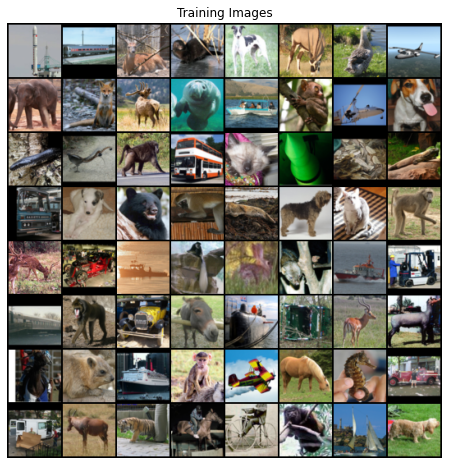

In [7]:
# load dataset
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transforms = T.Compose([T.Resize(image_size),T.CenterCrop(image_size), T.ToTensor(), T.Normalize(*stats)])

data_train = STL10('./datasets/stl10',split='train+unlabeled', download=True, transform=transforms)
data_test  = STL10('./datasets/stl10', split='test', transform=transforms)
data = ConcatDataset([data_train, data_test])
#data = ImageFolder('./thumbnails128x128', transform=transforms)

data_loader = DataLoader(data, batch_size, shuffle=True, num_workers=3, pin_memory=True)
data_loader = DeviceDataLoader(data_loader, device)
total_step = len(data_loader)

from torchvision.transforms.functional import normalize
# plot some train images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2, normalize=True).cpu(),(1,2,0)))

# Training Setup

In [8]:
def train(epochs):
  for epoch in range(epochs):
    for i, (images, _) in enumerate(data_loader):
      image = images.to(device)
      b_size = image.size(0)

      # Train the discriminator and generator
      opt_d.zero_grad()
        
      # Loss for real images
      real_preds = discriminator(images)
      real_targets = torch.ones(images.size(0), 1, device=device)
      real_loss = criterion(real_preds, real_targets)
      real_score = torch.mean(real_preds).item()

      latent = torch.randn(batch_size, z_dim, 1, 1, device=device)
      fake_images = generator(latent)


      # Pass fake images through discriminator
      fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
      fake_preds = discriminator(fake_images)
      fake_loss = criterion(fake_preds, fake_targets)
      fake_score = torch.mean(fake_preds).item()

      # Combine losses
    
      d_loss = real_loss + fake_loss
      # Reset gradients
      reset_grad()
      # Compute gradients
      d_loss.backward()
      # Adjust the parameters using backprop
      opt_d.step()

      # Train Generator
      opt_g.zero_grad()
      z = torch.randn(batch_size, z_dim, 1, 1).to(device)
      fake_images = generator(z)
      labels = torch.ones(batch_size, 1).to(device)
      g_loss = criterion(discriminator(fake_images), labels)

      # Backprop and optimize
      reset_grad()
      g_loss.backward()
      opt_g.step()
    

      # Inspect the losses
      if (i+1) % 250 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, real_score: {:.2f}, fake_score: {:.2f}' 
                  .format(epoch, epochs, i+1, total_step, d_loss, g_loss, 
                          real_score, fake_score))
        
    # Sample and save images
    with torch.no_grad():
      samples = generator(torch.randn(batch_size, z_dim, 1, 1).to(device))
      show_samples(samples,8)
      save_fake_images(epoch+1,show=False)

In [10]:
train(50)

Epoch [0/50], Step [250/1766], d_loss: 0.0838, g_loss: 7.0079, real_score: 0.98, fake_score: 0.06


KeyboardInterrupt: ignored

In [15]:
loss_fn_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/alex.pth


In [19]:
def get_closest_img(reals, fakes):
    min_, real, fake = float('inf'), None, None    
    for r_image in reals:
        for f_image in fakes:
            d = loss_fn_alex(r_image, f_image).flatten().item()
            if d < min_:
                min_ = d
                real = r_image
                fake = f_image
    return (min_, real, fake)

def get_n_best_images(num_samples=8):
    samples = []
    with torch.no_grad():
        pbar = tqdm(total=num_samples)
        for (reals, _) in data_loader:
            noise = torch.randn(256, z_dim, 1, 1, device=device)
            fakes = generator(noise)
            samples.append(get_closest_img(reals.to(device), fakes))
            pbar.update(1)
            if len(samples) >= num_samples:
                pbar.close()
                break
    samples.sort(key=lambda x: x[0])
    return samples

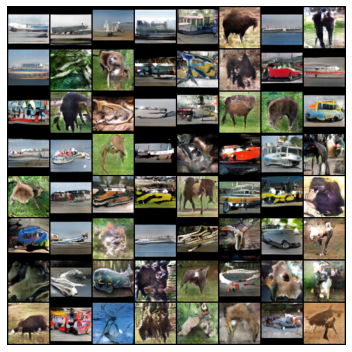

In [26]:
# plot the best samples
# samples = get_n_best_images(64)
grid = get_grid([i[-1] for i in samples])
plot_grid(grid, w=7, h=5, fname="best.png")

#Loss

In [33]:
d_losses_list = [tensor.item() for tensor in d_losses]
g_losses_list = [tensor.item() for tensor in g_losses]

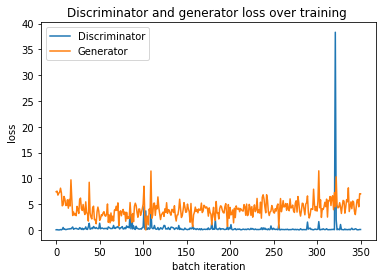

In [34]:
plt.plot(d_losses_list, '-')
plt.plot(g_losses_list, '-')
plt.xlabel('batch iteration')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Discriminator and generator loss over training ')
plt.savefig(f"loss.png", dpi=300)
plt.show()


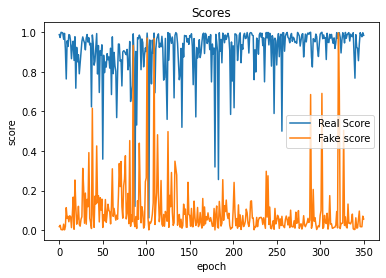

In [35]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Interpolation

In [37]:
def interpolate(use_fixed=False, fname=None, size=7):
    col_size = int(np.sqrt(batch_size))
    z = fixed_noise if use_fixed else torch.randn(batch_size, z_dim, 1, 1, device=device)
    # z0 for top row
    z0 = z[0:col_size].repeat(col_size,1,1,1) 
    # z1 for bottom row
    z1 = z[batch_size-col_size:].repeat(col_size,1,1,1) 
    t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(batch_size,1,1,1).to(device)
    
    lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
    lerp_g = generator(lerp_z) # sample the model at the resulting interpolated latents
    plot_grid(get_grid(lerp_g), fname=fname, w=size, h=size)

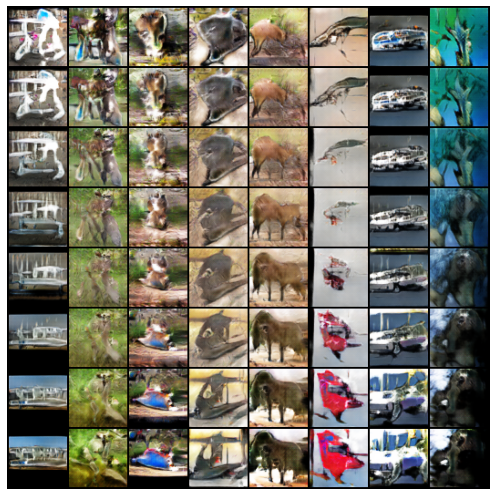

In [38]:
interpolate(use_fixed=True, fname='interpolants.png')